# 01. Chequeo de Sanidad: `fermat` vs. `networkx`
`networkx` (o `igraph`, a tal fin) 

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris
import networkx as nx

In [2]:
X, y = load_iris(return_X_y=True, as_frame=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [4]:
G = nx.complete_graph(len(X))

In [5]:
nx.set_node_attributes(G, X.to_dict(orient="index"))
nx.set_node_attributes(G, y, name="y")

In [6]:
alpha, path_method = 2, "FW"
fermat = Fermat(alpha=alpha, path_method=path_method)
dists = distance_matrix(X, X)


In [7]:
# %%timeit
fermat.fit(dists)
fdists = fermat.get_distances()
nx.set_edge_attributes(
    G, {(i, j): fdists[i, j] for i in range(N) for j in range(i)}, name="fermat_dist"
)


In [8]:
for (i, j), d in nx.get_edge_attributes(G, "fermat_dist").items():
    assert fdists[i, j] == d

In [9]:
# Reverse check
assert np.all(
    fdists[i, j] == d
    for (i, j), d
    in nx.get_edge_attributes(G, "fermat_dist").items()
)


In [10]:
# %%timeit
nx.set_edge_attributes(
    G, {(i, j): dists[i, j] ** alpha for i in range(N) for j in range(i)}, name="alpha_dist"
)
nxdists = nx.shortest_paths.floyd_warshall_numpy(G, weight="alpha_dist")

In [11]:
# Aparentemente las referencias locales (`nxdists`) dentro de %%timeit no perduran
nxdists = nx.shortest_paths.floyd_warshall_numpy(G, weight="alpha_dist")
np.allclose(fdists, nxdists)

False

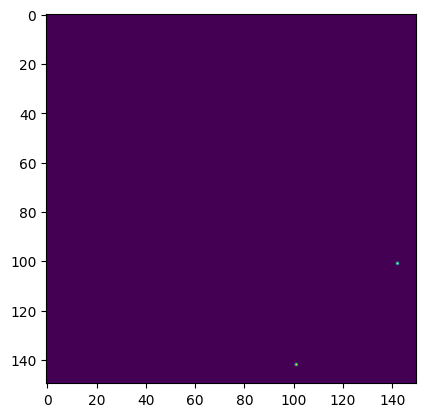

In [12]:
diff = np.abs(nxdists - fdists)
plt.imshow(diff)

In [13]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

In [14]:
max_idx = diff.argmax()
max_i, max_j = max_idx // N, max_idx % N
diff[max_i, max_j]
pd.concat([X.loc[[max_i, max_j]], y[[max_i, max_j]]], axis=1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
101,5.8,2.7,5.1,1.9,2
142,5.8,2.7,5.1,1.9,2


Son dos observaciones idénticas! Probablemente uno de los dos algoritmos no está permitiendo caminos mínimos de longitud 0.

In [15]:
nxdists[max_i, max_j], fdists[max_i, max_j]

(0.0, 0.1399999999999999)

In [16]:
fdists[max_i, max_i]

0.0

Curioso. La distancia de `max_i` a sí mismo es 0, pero no así a `max_j`. Asumimos que `Fermat` llegó a la distancia `fdists[max_i, max_j]` saltando al NN(1) de `max_i` que _no está en su mismo lugar_ (como `max_j`), y volviendo a `max_i`, así que conjeturamos que la distancia de `max_i` a NN(1) _según Fermat_, tiene que ser `fdists[max_i, max_j] / 2`. 

In [17]:
nn1 = fdists[max_i].argsort()[1]  # el argmin absoluto es `max_i`, me interesa el segundo
assert fdists[max_i, nn1] == fdists[max_i, max_j] / 2

Era verdad! Qué cagada, a esta altura más bien tendemos a desconfiar de `Fermat.fit()`. Habremos de verificar que las `N` observaciones de X sean únicas.

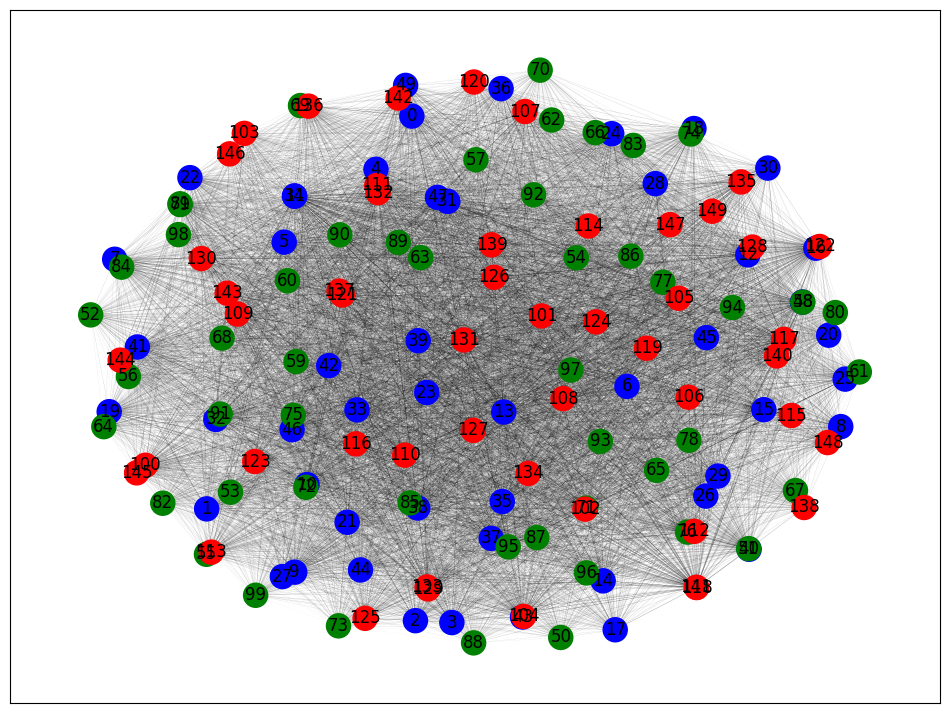

In [18]:
plt.figure(figsize=(12, 9))
nx.draw_networkx(
    G,
    width=1e-2 * np.sqrt([G.edges[e].get("alpha_dist") for e in G.edges]),
    node_color=[
        {0: "blue", 1: "green", 2: "red"}[G.nodes[n].get("y")] for n in G.nodes
    ],
)
